In [2]:
import freud
import gsd.fl
import gsd.hoomd
import numpy as np
import matplotlib.pyplot as plt
import numpy
print(gsd.__version__)
print(freud.__version__)
plt.rcParams.update({'font.size': 26})
#EJ: I did a "conda install -c conda-forge freud gsd" yesterday and may have relatively newer versions-
#EJ: Try this conda install above if you're getting errors

2.1.2
2.2.0


In [3]:
temps = ['1','10', '30', '50']
bond_weights = ['1','2','4']
def get_files(T=None, bw=None):
    file_paths=[]
    if T: 
        for i in bond_weights:
            file_paths.append("bondweight{}_T{}/data.gsd".format(i,T))
    if bw:
        for i in temps:
            file_paths.append("bondweight{}_T{}/data.gsd".format(bw,i))
    return file_paths

In [4]:
testfile = get_files(bw='1')
print(testfile)
f = gsd.fl.open(testfile[0],'rb')

['bondweight1_T1/data.gsd', 'bondweight1_T10/data.gsd', 'bondweight1_T30/data.gsd', 'bondweight1_T50/data.gsd']


In [32]:
def average_rdf(file, types, num_frames=1, r_max=8, dr=0.25):
    gsd_file = gsd.fl.open(file, "rb")
    trajectory = gsd.hoomd.HOOMDTrajectory(gsd_file)
    traj_slice = trajectory[-num_frames:] #uses the last num_frames frames
    rdf = freud.density.RDF(r_max/dr,r_max)
    for frame in traj_slice:
        x,y,z = frame.configuration.box[:3]
        box = freud.box.Box(x,y,z)
        if types[0]=='all':
            positions = frame.particles.position
        else:
            positions = []
            for idx, type_id in enumerate(frame.particles.typeid):
                if frame.particles.types[type_id] in types:
                    positions.append(frame.particles.position[idx])
        #print('# OF PARTICLES = {}'.format(len(positions)))
        rdf.compute(system=(box,positions),reset=False, neighbors={'mode': 'ball', 'r_max': r_max, 'exclude_ii':True})   
    gsd_file.close()
    return numpy.arange(0,r_max,dr), rdf.rdf

def find_starting_frame(trajectory):
    '''
    Checks to see where shrinking stops
    If the sim doesnt involve shrinking, then starting frame should be 0
    '''
    box_dims = trajectory[-1].configuration.box[:3]
    for i in range(0, len(trajectory)):
        if np.array_equal(trajectory[i].configuration.box[:3], box_dims):
            starting_index = i
            break
    return(starting_index)

def plot_rdf(files, labels, types, title, color, num_frames=1, r_max=8, dr=0.25):
    '''
    This is the primary funciton you will interface with.
    files, labels, and types need to be passed into the funcion as lists.
    Even if you are only plotting one file, pass in a list of length 1 [file]
    
    files: Path to the .gsd file you want to plot
    types: The actual atom-types used/created in hoomd.
    lables: Your own labels, used to create the plot legend
            what is different between the files you're plotting? temperature for example
            [2.0, 1.8, 1.6]
    title: Plot title
    num_frames: How many frames do you want to average over? This starts at the last frame   
    '''
    
    fig = plt.figure()
    for i, f in enumerate(files):
        x, y = average_rdf(f, types, num_frames, r_max, dr)
        plt.plot(x, y, color, label = labels[i])
    plt.legend()
    plt.title(title)
    plt.show()

def plot_rdf2(files, labels, types, title, num_frames=1, r_max=4, dr=0.05, colors=['g','g','g']):
    '''
    This is the primary funciton you will interface with.
    files, labels, and types need to be passed into the funcion as lists.
    Even if you are only plotting one file, pass in a list of length 1 [file]
    
    files: Path to the .gsd file you want to plot
    types: The actual atom-types used/created in hoomd.
    lables: Your own labels, used to create the plot legend
            what is different between the files you're plotting? temperature for example
            [2.0, 1.8, 1.6]
    title: Plot title
    num_frames: How many frames do you want to average over? This starts at the last frame   
    '''
    lines = ['solid','dotted','dashed']
    markers = ['o','^','s']
    for i,f in enumerate(files):
        x, y = average_rdf(f, types, num_frames, r_max, dr)
        plt.plot(x, y, color=colors[i], linestyle=lines[i],label = None)
        #plt.plot(x, y, color=colors[i], marker=markers[i], markersize=10, fillstyle='none', label = labels[i])
        print(i," done")
    plt.legend(loc=1)
    plt.xlabel('r')
    plt.ylabel('g(r)')
    plt.savefig(types[0]+"-rdf.png",dpi=300)
    plt.show()



In [ ]:
#bw1 T=1 and T=50 with new analysis to compare against figure in paper
plot_rdf2(['bondweight1_T1/data.gsd', 'bondweight1_T10/data.gsd','bondweight1_T50/data.gsd'], labels=None, title=None, num_frames=6, types=['all'],colors=['k','k','k'])
plot_rdf2(['bondweight1_T1/data.gsd', 'bondweight1_T10/data.gsd', 'bondweight1_T50/data.gsd'], labels=None, title=None, num_frames=6, types=['A','B'],colors=['darkviolet','darkviolet','darkviolet'])
plot_rdf2(['bondweight1_T1/data.gsd', 'bondweight1_T10/data.gsd','bondweight1_T50/data.gsd'], labels=None, title=None, num_frames=6, types=['C'])

0  done
1  done


No handles with labels found to put in legend.


0  done
1  done


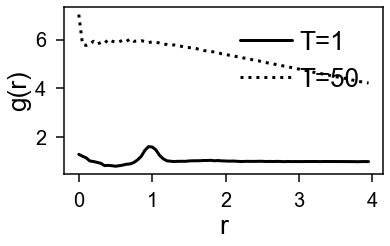

0  done
1  done


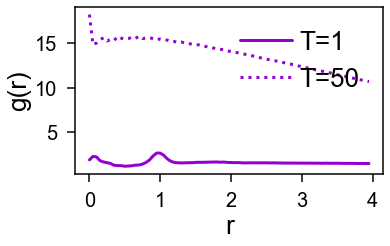

0  done
1  done


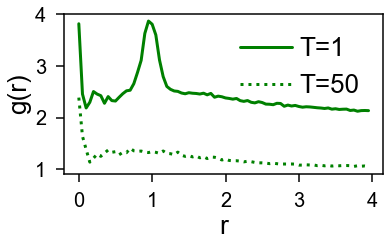

In [15]:
#bw1 T=1 and T=50 with new analysis to compare against figure in paper; only 1 frame
plot_rdf2(['bondweight1_T1/data.gsd', 'bondweight1_T50/data.gsd'], labels=['T=1','T=50'], title=None, num_frames=1, types=['all'],colors=['k','k','k'])
plot_rdf2(['bondweight1_T1/data.gsd', 'bondweight1_T50/data.gsd'], labels=['T=1','T=50'], title=None, num_frames=1, types=['A','B'],colors=['darkviolet','darkviolet','darkviolet'])
plot_rdf2(['bondweight1_T1/data.gsd', 'bondweight1_T50/data.gsd'], labels=['T=1','T=50'], title=None, num_frames=1, types=['C'])

In [ ]:
#Bw 4 plots
plot_rdf2(['bondweight4_T1/data.gsd', 'bondweight4_T30/data.gsd', 'bondweight4_T50/data.gsd'], labels=None, title=None, num_frames=6, types=['all'],colors=['k','k','k'])
plot_rdf2(['bondweight4_T1/data.gsd', 'bondweight4_T30/data.gsd', 'bondweight4_T50/data.gsd'], labels=None, title=None, num_frames=6, types=['A','B'],colors=['darkviolet','darkviolet','darkviolet'])
plot_rdf2(['bondweight4_T1/data.gsd', 'bondweight4_T30/data.gsd', 'bondweight4_T50/data.gsd'], labels=None, title=None, num_frames=6, types=['C'])

In [ ]:
#BW2
plot_rdf2(['bondweight2_T1/data.gsd', 'bondweight2_T10/data.gsd', 'bondweight2_T30/data.gsd', 'bondweight2_T50/data.gsd'], title=None, num_frames=6, types=['all'],colors=['k','k','k'])
plot_rdf2(['bondweight2_T1/data.gsd', 'bondweight2_T10/data.gsd', 'bondweight2_T30/data.gsd', 'bondweight2_T50/data.gsd'], title=None, num_frames=6, types=['A','B'],colors=['darkviolet','darkviolet','darkviolet'])
plot_rdf2(['bondweight2_T1/data.gsd', 'bondweight2_T10/data.gsd', 'bondweight2_T30/data.gsd', 'bondweight2_T50/data.gsd'], title=None, num_frames=6, types=['C'])

In [ ]:
plot_rdf2(['bondweight10_T10/data.gsd', 'bondweight10_T30/data.gsd', 'bondweight10_T50/data.gsd'], title=None, num_frames=6, types=['all'],colors=['k','k','k'])
plot_rdf2(['bondweight10_T10/data.gsd', 'bondweight10_T30/data.gsd', 'bondweight10_T50/data.gsd'], title=None, num_frames=6, types=['A','B'],colors=['darkviolet','darkviolet','darkviolet'])
plot_rdf2(['bondweight10_T10/data.gsd', 'bondweight10_T30/data.gsd', 'bondweight10_T50/data.gsd'], title=None, num_frames=6, types=['C'])

In [ ]:
plot_rdf2(['bondweight30_T10/data.gsd', 'bondweight30_T30/data.gsd', 'bondweight30_T50/data.gsd'], title=None, num_frames=6, types=['all'],colors=['k','k','k'])
plot_rdf2(['bondweight30_T10/data.gsd', 'bondweight30_T30/data.gsd', 'bondweight30_T50/data.gsd'], title=None, num_frames=6, types=['A','B'],colors=['darkviolet','darkviolet','darkviolet'])
plot_rdf2(['bondweight30_T10/data.gsd', 'bondweight30_T30/data.gsd', 'bondweight30_T50/data.gsd'], title=None, num_frames=6, types=['C'])

# Temperature of 1, bond weights 1, 2, and 4.

The gsd files for a bondweight of 10 and 30 are bad because a bondweight that high at a temperature this
low didn't work. With the bondweights of 1, 2, and 4, the rdfs are the same when comparing all of the atom types together. This can be confirmed with the vmd images. From the vmd images we can see that the C types phase separate out into their own structure and are not mixed within the A and B types, whereas the A and B types fill in the rest of the space around the C types. The fact that the C types separate out into their own structure can be seen in the C-type rdf where the peak reaches 3, indicating that the C types are three times as likely to be found at a distance of ~1. This is also confirmed in the vmd images. 

# For my own thought process: 
The temperature of this system is relatively low, so in the time that it takes to complete the simulation, the A, B, and C's aren't expected to move as much as they would at a higher temperature. At lower temperature it's harder for bonds to form to begin with.

0  done
1  done
2  done


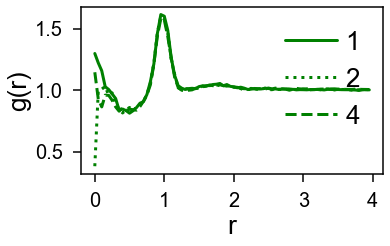

0  done
1  done
2  done


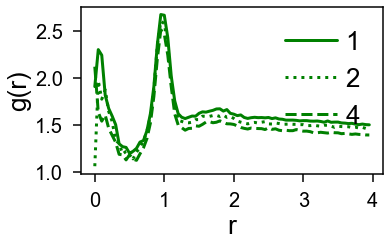

0  done
1  done
2  done


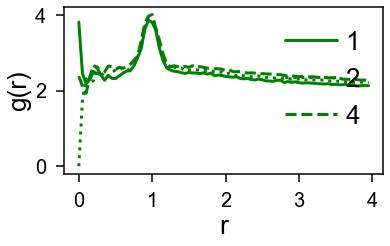

In [68]:
plot_rdf2(get_files(T='1'), labels=bond_weights, types=['all'], title='Temp = 1, Type = All')
plot_rdf2(get_files(T='1'), labels=bond_weights, types=['A','B'], title='Temp = 1, Type = A and B')
plot_rdf2(get_files(T='1'), labels=bond_weights, types=['C'], title='Temp = 1, Type = C')

In [5]:
temps = ['1','10', '30', '50']
bond_weights = ['1','2','10','30']
def get_files(T=None, bw=None):
    file_paths=[]
    if T: 
        for i in bond_weights:
            file_paths.append("bondweight{}_T{}/data.gsd".format(i,T))
    if bw:
        for i in temps:
            file_paths.append("bondweight{}_T{}/data.gsd".format(bw,i))
    return file_paths

# Temperature of 10, bondweights of 1, 2, 10, and 30.

A bondweight of 4 was found to be a bad GSD file and the reason why is unknown. (We can dive into this if it is worth the time?) We can see that there is still a trend with the data that we were able to plot. At lower bond weights (1 and 2) the liklihood of finding an atom at a distance of ~1 is around 2 and those rdf's are nearly identical. If we look at the vmd images. In the images we can see that the A-B atoms form their own tight structure and separate from the C atoms and then the C atoms fill in the empty space (oppostite from T=1). From a temperature of 1 to a temperature of 10 the C atoms and A-B atoms have swapped roles which is an interesting point to make. From this we can infer that raising the temperature increases the possibility that A-B will make a bond. In real world applications this makes sense. Increasing temperature is a way to speed up a reaction, and induce more bonding. At the bond weights of 10 and 30, we notice that the liklihood of finding an atom decreases with increasing bondweight, which is to be expected.

If we take a look at the rdf function for the C's, they've decreased in comparison to T = 1. In the vmd figures we can visually see this because the C's are no longer phase separated out and instead spread out around the phase separated A-B's. 

# We expect for the lower bond weights that reacted faster to have a dense clump of A's and B's. If bonding is high, what does that mean for the morphology? If bonding is really fast, we can expect that the C is locked in before it has time to phase separate out. At higher temperature the C's are more apt to expand out like a gas because they don't bond to anything.

# At a bondweight of 1 and 2 and a T=10 there are big slabs of A-Bs, at a bond weight of 10 there is a slab with some holes, and at a bondweight of 30 they are more spread out in a slab with some holes

# OF PARTICLES = 50000
# OF PARTICLES = 50000
# OF PARTICLES = 50000
# OF PARTICLES = 50000


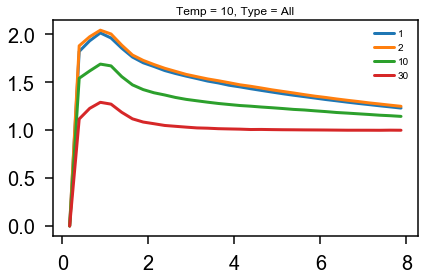

# OF PARTICLES = 30000
# OF PARTICLES = 30000
# OF PARTICLES = 30000
# OF PARTICLES = 30000


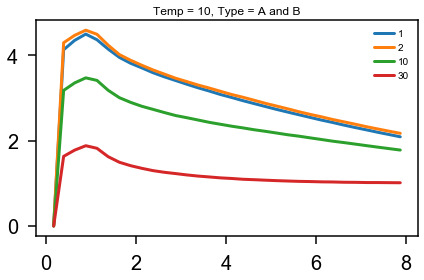

# OF PARTICLES = 20000
# OF PARTICLES = 20000
# OF PARTICLES = 20000
# OF PARTICLES = 20000


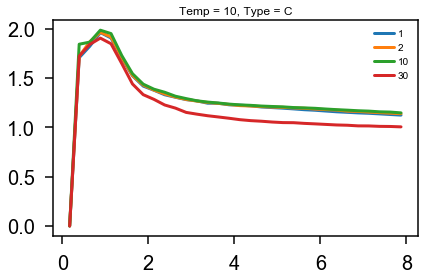

In [11]:
plot_rdf(get_files(T='10'), labels=bond_weights, types=['all'], title='Temp = 10, Type = All')
plot_rdf(get_files(T='10'), labels=bond_weights, types=['A','B'], title='Temp = 10, Type = A and B')
plot_rdf(get_files(T='10'), labels=bond_weights, types=['C'], title='Temp = 10, Type = C')

In [18]:
temps = ['1','10', '30', '50']
bond_weights = ['4','10','30']
def get_files(T=None, bw=None):
    file_paths=[]
    if T: 
        for i in bond_weights:
            file_paths.append("bondweight{}_T{}/data.gsd".format(i,T))
    if bw:
        for i in temps:
            file_paths.append("bondweight{}_T{}/data.gsd".format(bw,i))
    return file_paths

# Temperature of 30, Bondweights of 4, 10, and 30

At a temperature of 30, bondweights 1 and 2 were not run. The C-C's are uniform and come down to one. The funny looking peaks might indicate that it's hot enough that particles can squish closer together than they otherwise would at a lower temperature.

At a bondweight of 30 we don't expect many secondary bonds to happen, so it makes sense that that A-B and C-C are basically uniform. 

At a bondweight of 4 and 10 A-B are pretty clumped together

# OF PARTICLES = 50000
# OF PARTICLES = 50000
# OF PARTICLES = 50000


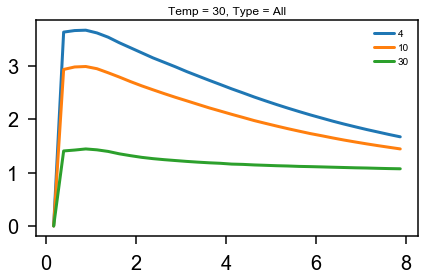

# OF PARTICLES = 30000
# OF PARTICLES = 30000
# OF PARTICLES = 30000


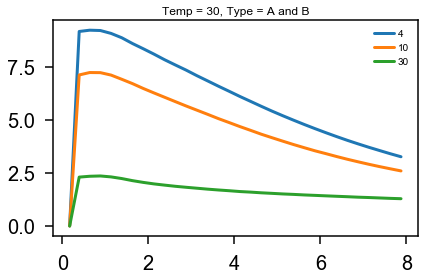

# OF PARTICLES = 20000
# OF PARTICLES = 20000
# OF PARTICLES = 20000


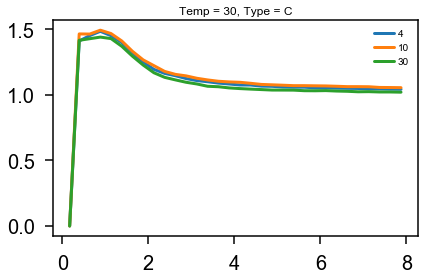

In [19]:
plot_rdf(get_files(T='30'), labels=bond_weights, types=['all'], title='Temp = 30, Type = All')
plot_rdf(get_files(T='30'), labels=bond_weights, types=['A','B'], title='Temp = 30, Type = A and B')
plot_rdf(get_files(T='30'), labels=bond_weights, types=['C'], title='Temp = 30, Type = C')

In [20]:
temps = ['1','10', '30', '50']
bond_weights = ['1','2','4','10','30']
def get_files(T=None, bw=None):
    file_paths=[]
    if T: 
        for i in bond_weights:
            file_paths.append("bondweight{}_T{}/data.gsd".format(i,T))
    if bw:
        for i in temps:
            file_paths.append("bondweight{}_T{}/data.gsd".format(bw,i))
    return file_paths

As T increases the C-C peaks go down and the faster the peak returns to one. At 50, the C-Cs are as close to an ideal gas as we have seen. The interesting part is the width of the peak. From a temperature of 1 to a temperature of 10 the C's changes a lot 

# OF PARTICLES = 50000
# OF PARTICLES = 50000
# OF PARTICLES = 50000
# OF PARTICLES = 50000
# OF PARTICLES = 50000


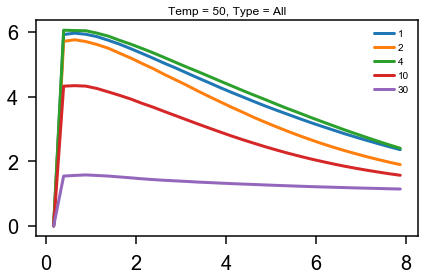

# OF PARTICLES = 30000
# OF PARTICLES = 30000
# OF PARTICLES = 30000
# OF PARTICLES = 30000
# OF PARTICLES = 30000


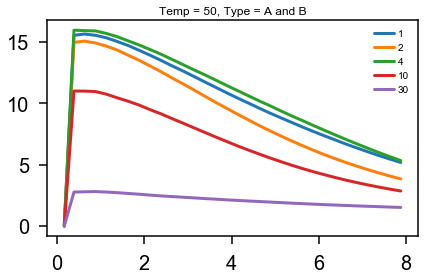

# OF PARTICLES = 20000
# OF PARTICLES = 20000
# OF PARTICLES = 20000
# OF PARTICLES = 20000
# OF PARTICLES = 20000


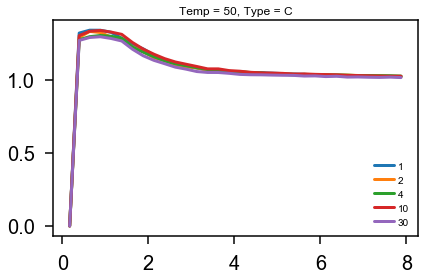

In [21]:
plot_rdf(get_files(T='50'), labels=bond_weights, types=['all'], title='Temp = 50, Type = All')
plot_rdf(get_files(T='50'), labels=bond_weights, types=['A','B'], title='Temp = 50, Type = A and B')
plot_rdf(get_files(T='50'), labels=bond_weights, types=['C'], title='Temp = 50, Type = C')

# OF PARTICLES = 50000
# OF PARTICLES = 50000
# OF PARTICLES = 50000
# OF PARTICLES = 50000
# OF PARTICLES = 50000


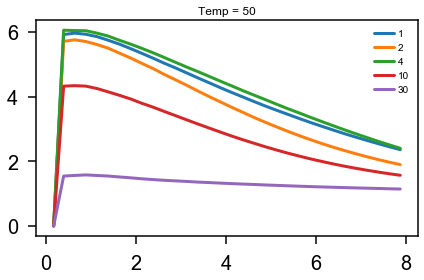

In [30]:
plot_rdf(get_files(T='50'), labels=bond_weights, types=['all'], title='Temp = 50')

In [3]:
temps = ['1','10', '50']
bond_weights = ['1','2','4','10','30']
def get_files(T=None, bw=None):
    file_paths=[]
    if T: 
        for i in bond_weights:
            file_paths.append("bondweight{}_T{}/data.gsd".format(i,T))
    if bw:
        for i in temps:
            file_paths.append("bondweight{}_T{}/data.gsd".format(bw,i))
    return file_paths

In [6]:
plot_rdf2(get_files(bw='1'), labels=temps, title=None, types=['all'])
plot_rdf2(get_files(bw='1'), labels=temps, title=None, types=['A','B'])
plot_rdf2(get_files(bw='1'), labels=temps, title=None, types=['C'])

TypeError: 'Snapshot' object is not iterable

<Figure size 432x288 with 0 Axes>

# OF PARTICLES = 50000
# OF PARTICLES = 50000
# OF PARTICLES = 50000


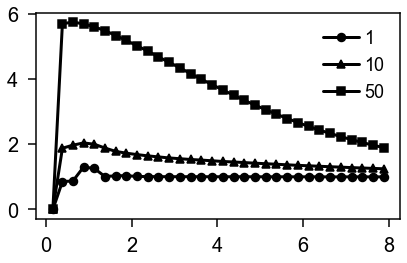

# OF PARTICLES = 30000
# OF PARTICLES = 30000
# OF PARTICLES = 30000


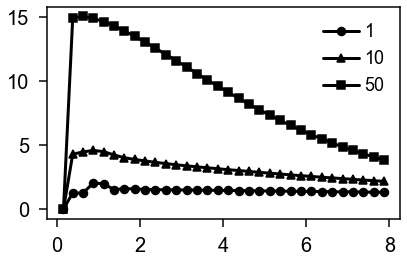

# OF PARTICLES = 20000
# OF PARTICLES = 20000
# OF PARTICLES = 20000


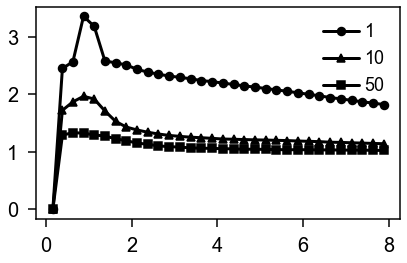

In [41]:
plot_rdf2(get_files(bw='2'), labels=temps, title=None, types=['all'])
plot_rdf2(get_files(bw='2'), labels=temps, title=None, types=['A','B'])
plot_rdf2(get_files(bw='2'), labels=temps, title=None, types=['C'])

In [42]:
temps = ['10','30', '50']
bond_weights = ['1','2','4','10','30']
def get_files(T=None, bw=None):
    file_paths=[]
    if T: 
        for i in bond_weights:
            file_paths.append("bondweight{}_T{}/data.gsd".format(i,T))
    if bw:
        for i in temps:
            file_paths.append("bondweight{}_T{}/data.gsd".format(bw,i))
    return file_paths

# OF PARTICLES = 50000
# OF PARTICLES = 50000
# OF PARTICLES = 50000


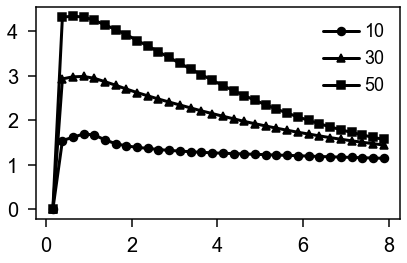

# OF PARTICLES = 30000
# OF PARTICLES = 30000
# OF PARTICLES = 30000


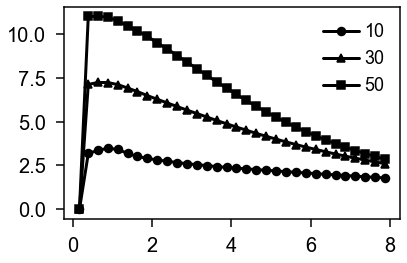

# OF PARTICLES = 20000
# OF PARTICLES = 20000
# OF PARTICLES = 20000


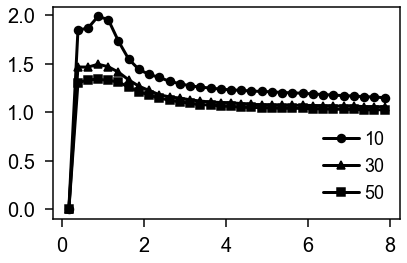

In [43]:
plot_rdf2(get_files(bw='10'), labels=temps, title=None, types=['all'])
plot_rdf2(get_files(bw='10'), labels=temps, title=None, types=['A','B'])
plot_rdf2(get_files(bw='10'), labels=temps, title=None, types=['C'])

# OF PARTICLES = 50000
# OF PARTICLES = 50000
# OF PARTICLES = 50000


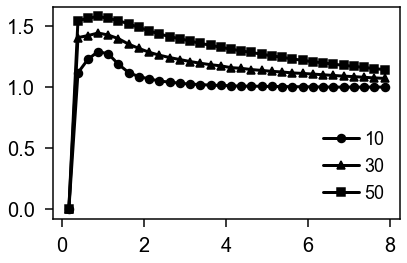

# OF PARTICLES = 30000
# OF PARTICLES = 30000
# OF PARTICLES = 30000


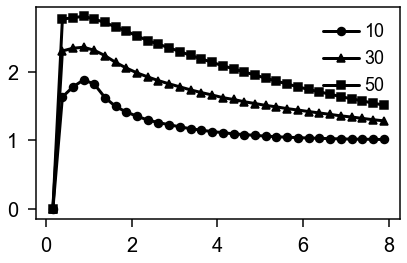

# OF PARTICLES = 20000
# OF PARTICLES = 20000
# OF PARTICLES = 20000


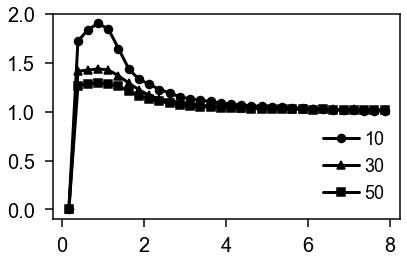

In [44]:
plot_rdf2(get_files(bw='30'), labels=temps, title=None, types=['all'])
plot_rdf2(get_files(bw='30'), labels=temps, title=None, types=['A','B'])
plot_rdf2(get_files(bw='30'), labels=temps, title=None, types=['C'])